In [ ]:
from dotenv import load_dotenv
load_dotenv("../config.env")

True

In [26]:
from coamp_graph import Graph
import coamp_graph_notebook_utils
import numpy as np
import matplotlib.pyplot as plt

In [16]:
project_list = ['GBM39', 'COLO320'] # , 'CCLE'
df, __ = coamp_graph_notebook_utils.concat_projects(project_list)

In [18]:
df.shape

(14, 25)

In [19]:
graph = Graph(df)
nodes = graph.Nodes()
edges = graph.Edges()

Retrieved locations for 22998 GRCh38 genes in 0.33 seconds
Loaded 28555 genes from provided reference files
Gene record creation time: 1.64 seconds
31508
Matched location data for 22976 genes
Filtering features took 0.0027 seconds, resulting in 3 features
Preprocessing intervals and reformatting dataset took 0.0020 seconds
Starting CreateNodes with 3 rows
Note: 0 genes are amplified on multiple feature IDs in the same sample
TEST: 40 searches where gene's location is found
TEST: 39 searches where gene's chr on interval and gene's location is matched to an interval
TEST: 1 searches where gene's chr on interval but gene's location is NOT matched to an interval (1 unique nodes)
TEST: 0 searches where gene's chr not on interval (0 unique nodes)
Processing 40 genes took 0.0053 seconds, resulting in 26 unique nodes
0 genes were not amplified on any merged intervals
Total CreateNodes execution: 0.0053 seconds
Starting CreateEdges with 26 nodes
Building features index took 0.0000 seconds: 3 un

In [20]:
graph.genes_with_no_chr_match_list

[]

In [21]:
edges[0]

{'source': 'CCAT2',
 'target': 'CDX2',
 'weight': 0.5,
 'inter': {'COLO320HSR'},
 'union': {'COLO320DM', 'COLO320HSR'},
 'distance': -1,
 'p_d_D': -1,
 'p_values': [-1, -1, 0.19914704548925982, -1],
 'odds_ratios': [-1, -1, 3.783083143243502, -1],
 'q_values': [-1, -1, 0.19914704548925982, -1]}

In [22]:
p_single, p_multi_interval, p_multi_chr, p_multi_ecdna = [], [], [], []
q_single, q_multi_interval, q_multi_chr, q_multi_ecdna = [], [], [], []
na_counter = 0
for edge in edges:
    p_vals = edge.get('p_values', [-1, -1, -1, -1])
    q_vals = edge.get('q_values', [-1, -1, -1, -1])
    if p_vals == [-1, -1, -1, -1]:# and edge.get('missing_interval_data'):
        na_counter += 1
    if len(p_vals) == 4:
        p_single.append(p_vals[0])
        p_multi_interval.append(p_vals[1])
        p_multi_chr.append(p_vals[2])
        p_multi_ecdna.append(p_vals[3])
    if len(q_vals) == 4:
        q_single.append(q_vals[0])
        q_multi_interval.append(q_vals[1])
        q_multi_chr.append(q_vals[2])
        q_multi_ecdna.append(q_vals[3])
na_counter

0

In [23]:
def every_fifth_percentile(data):
    data = np.array(data)
    percentiles = np.arange(5, 100, 5)
    return {p: np.percentile(data, p) for p in percentiles}

# Calculate the percentiles and format them
def print_percentiles_aligned(data):
    results = every_fifth_percentile(data)

    # Format and find max width for alignment
    formatted = {k: f"{v:.4f}" for k, v in results.items()}
    max_width = max(len(val) for val in formatted.values())

    for k in sorted(formatted):
        print(f"{k:>2}th percentile: {formatted[k]:>{max_width}}")

In [24]:
def plot_p_values(p_values, title="p_values"):
    filtered = [p for p in p_values if p != -1]
    print(f"{len(filtered)} valid p-values from {len(p_values)} edges\n")
    
    print_percentiles_aligned(filtered)
    
    plt.figure(figsize=(8, 6))
    plt.hist(filtered, bins=50, alpha=0.7)
    plt.title(title)
    plt.xlabel("p-values")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    


122 valid p-values from 181 edges

 5th percentile: 0.2729
10th percentile: 0.2904
15th percentile: 0.2904
20th percentile: 0.3693
25th percentile: 0.3693
30th percentile: 0.3713
35th percentile: 0.4011
40th percentile: 0.4030
45th percentile: 0.4073
50th percentile: 0.4105
55th percentile: 0.4130
60th percentile: 0.4136
65th percentile: 0.4195
70th percentile: 0.4207
75th percentile: 0.4253
80th percentile: 0.4265
85th percentile: 0.4527
90th percentile: 0.4567
95th percentile: 0.4567


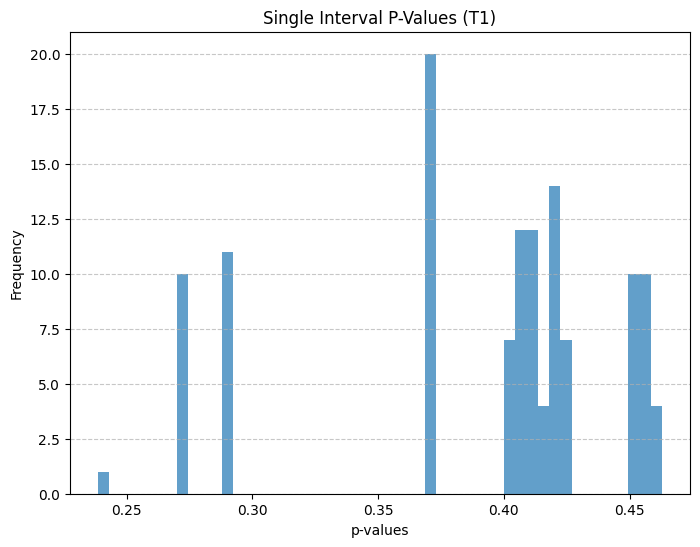

In [27]:
plot_p_values(p_single, title=f"Single Interval P-Values (T1)")

122 valid p-values from 181 edges

 5th percentile: 0.4628
10th percentile: 0.4628
15th percentile: 0.4628
20th percentile: 0.4628
25th percentile: 0.4628
30th percentile: 0.4628
35th percentile: 0.4628
40th percentile: 0.4628
45th percentile: 0.4628
50th percentile: 0.4628
55th percentile: 0.4628
60th percentile: 0.4628
65th percentile: 0.4628
70th percentile: 0.4628
75th percentile: 0.4628
80th percentile: 0.4628
85th percentile: 0.4628
90th percentile: 0.4628
95th percentile: 0.4628


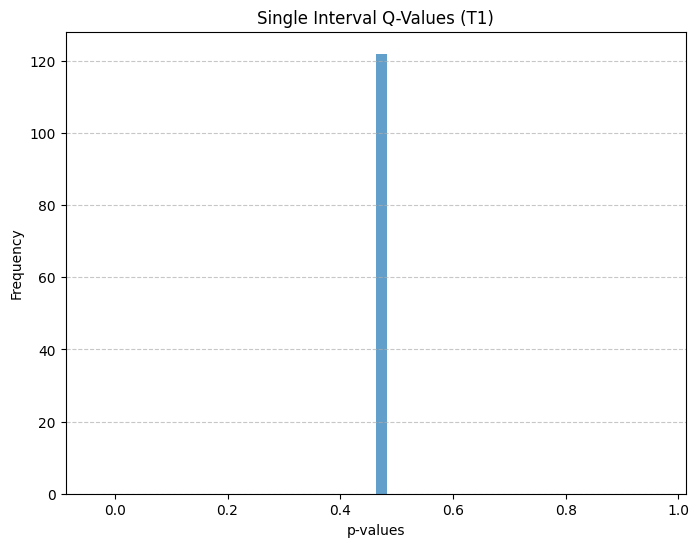

In [28]:
plot_p_values(q_single, title=f"Single Interval Q-Values (T1)")